In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If true, use the full dataset, otherwise use the toy dataset
use_full_ds = True

if use_full_ds:
    raw_data = np.loadtxt('zipcombo.dat')
else:
    raw_data = np.vstack((np.loadtxt('dtrain123.dat'), np.loadtxt('dtest123.dat')))

y_all = raw_data[:, 0]
x_all = raw_data[:, 1:]

#### Main Implementation of Kernel Perceptron for Polynomial kernels used in Q1-Q6

In [ ]:
class KernelPerceptron:
    """
    This is the implementation of the kernel perceptron for polynomial kernels. We intialize the paramteres and
    then train the model by iterating through the data and updating the active indices and alpha. 
    """
    def __init__(self, d=1, epochs=5):
        """
        Initialize the parameters where d is degree of the polynomial kernel, epochs is the number of, 
        active_indices contains the indices of the training samples which caused errors and alpha is the list containing the alpha values described in the report.
        """
        self.d = d
        self.epochs = epochs
        self.active_indices = []
        self.alpha = []
    
    def train(self, y_train, gram_mtx):  
        # initialize the active indices and alpha
        self.active_indices = []
        self.alpha = []

        # begin training loop
        for _ in range(self.epochs):

            # iterate over the labels
            for i in range(len(y_train)):

                # compute the score
                score = 0.0
                if len(self.active_indices) > 0:
                    score = np.dot(self.alpha, gram_mtx[i, self.active_indices] ** self.d)
                
                # if the score is not the same as the label, add the sample to the active indices
                if np.sign(score) != y_train[i]:
                    self.active_indices.append(i)
                    self.alpha.append(y_train[i])

    def predict_scores(self, gram_test_train):
        """
        This function computes the scores for the set.
        """
        # if there are no active indices, return all zero to prevent any errors
        if len(self.active_indices) == 0:
            return np.zeros(gram_test_train.shape[0])

        kvals = gram_test_train[:, self.active_indices] ** self.d
        return np.dot(kvals, self.alpha)

### Question 1 Solution is in the pdf portion of the report.

## Question 2

In [ ]:
class OneVsRestClassifier:
    """
    This is the one versus rest multi-class classifier using the kernel perceptron. The train function creates a binary classifier for each class.
    The predict function then uses these binary classifiers to predict the class of a new instance.
    """
    def __init__(self, d=1, epochs=5):
        """
        We initialize the parameters where d is the degree of the polynomial kernel, epochs is the number of iterations, classifiers is the list of classifiers and 
        classes is the list of classes.
        """
        self.d = d
        self.epochs = epochs
        self.classifiers = {}
        self.classes = []
        
    def train(self, y_train, gram_full, train_indices):
        # get unique classes and assign classifiers to an empty dictionary
        self.classes = np.unique(y_train)
        self.classifiers = {}

        # construct the gram matrix for the training set
        g_train = gram_full[np.ix_(train_indices, train_indices)]
        
        # iterate over the classes  
        for i in self.classes:

            # create the binary labels
            y_labels = np.where(y_train == i, 1.0, -1.0)

            # train the kernel perceptron
            kp_class = KernelPerceptron(d=self.d, epochs=self.epochs)
            kp_class.train(y_labels, g_train)
            self.classifiers[i] = kp_class
            
    def predict(self, gram_full, test_indices, train_indices):
        # get the gram matrix for the test and train set
        g_test_train = gram_full[np.ix_(test_indices, train_indices)]

        # init best scores and predictions
        best_scores = np.full(len(test_indices), -np.inf)
        predictions = np.zeros(len(test_indices))

        # iterate over the classes
        for c, kp in self.classifiers.items():
            # compute the scores
            scores = kp.predict_scores(g_test_train)

            # select the best score
            greater_than_best = scores > best_scores

            # set the prediction
            best_scores[greater_than_best] = scores[greater_than_best]
            predictions[greater_than_best] = c
        return predictions

## Question 3

In [16]:
# precompute the gram matrix
gram_full = np.dot(x_all, x_all.T)

# initialize the parameters
run_count = 20
degrees = range(1, 8)
n_samples = len(y_all)
n_train = int(0.8 * n_samples)

# initialize the training and test error arrays
training_err = np.zeros((run_count, len(degrees)))
test_err = np.zeros((run_count, len(degrees)))

print("Starting {run_count} runs...")

# we perform 20 runs on the randomly split dataset.
for i in range(run_count):
    print(f"Run {i+1}/{run_count}", end="\r")

    # randomize the sample indices
    permutated = np.random.permutation(n_samples)

    # split the data into train and test
    train_idx = permutated[:n_train]
    test_idx = permutated[n_train:]
    
    ytrain = y_all[train_idx]
    ytest = y_all[test_idx]


    # iterate over the polynomial degrees and train the model
    for j, d in enumerate(degrees):

        # instantiate and train the model
        model = OneVsRestClassifier(d=d, epochs=5)
        model.train(ytrain, gram_full, train_idx)
        
        # predict the training and test set
        training_pred = model.predict(gram_full, train_idx, train_idx)
        test_pred = model.predict(gram_full, test_idx, train_idx)
        
        # compute the training and test error
        training_err[i, j] = np.mean(training_pred != ytrain)
        test_err[i, j] = np.mean(test_pred != ytest)

print("Q3 Results")

df = pd.DataFrame({
    f'd={d}': [f"{np.mean(training_err[:, i]):.4f}±{np.std(training_err[:, i]):.4f}",
               f"{np.mean(test_err[:, i]):.4f}±{np.std(test_err[:, i]):.4f}"]
    for i, d in enumerate(degrees)
}, index=['Train', 'Test'])

print(df.to_string())

Starting {run_count} runs...
Q3 Results
                 d=1            d=2            d=3            d=4            d=5            d=6            d=7
Train  0.0778±0.0415  0.0115±0.0170  0.0032±0.0057  0.0017±0.0043  0.0004±0.0002  0.0003±0.0001  0.0003±0.0001
Test   0.0967±0.0380  0.0406±0.0154  0.0312±0.0049  0.0289±0.0054  0.0286±0.0037  0.0273±0.0032  0.0281±0.0030


### Questions 4, 5 and 6 : Cross-Validation, Confusion Matrix and Difficult to Classify Samples

In [ ]:
def k_fold_cv(gram_full, train_indices, y_train, degrees, k=5):
    """
    Performs k fold cross validation to select the best dimension. We iterate over the folds 
    where for each fold we train a model on the training set and evaluate it on the validation set. 
    We then return the best dimension. It takes in the gram matrix, the training indices, the training labels, 
    the polynomial degrees and the number of folds.
    """

    n_samples = len(train_indices)
    fold_len = n_samples // k

    # store indices for the subset of the data
    sub_indices = np.arange(n_samples)

    # shuffle the indices
    np.random.shuffle(sub_indices)
    
    fold_errors = {d: [] for d in degrees}
    
    # iterate over the folds
    for fold in range(k):

        # get the start and end indices of the current fold
        start = fold * fold_len
        end = (fold + 1) * fold_len if fold < k - 1 else n_samples
        
        # create a mask for the validation set for current fold
        val_mask = np.zeros(n_samples, dtype=bool)
        val_mask[sub_indices[start:end]] = True
        train_mask = ~val_mask
        
        # get the current train and validation indices and labels
        curr_train_idx = train_indices[train_mask]
        curr_val_idx = train_indices[val_mask]
        curr_y_train = y_train[train_mask]
        curr_y_val = y_train[val_mask]
        
        # iterate over the degrees and conclude the error rate for each degree
        for d in degrees:
            model = OneVsRestClassifier(d=d, epochs=5)
            model.train(curr_y_train, gram_full, curr_train_idx)
            preds = model.predict(gram_full, curr_val_idx, curr_train_idx)
            fold_errors[d].append(np.mean(preds != curr_y_val))
            
    avg_errors = {d: np.mean(errs) for d, errs in fold_errors.items()}
    return min(avg_errors, key=avg_errors.get)

optimal_dim = []
train_err_cv = []
test_err_cv= []

# setup confusion matrix for q5
unique_classes = np.unique(y_all)
class_map = {int(label): i for i, label in enumerate(unique_classes)}
n_classes = len(unique_classes)
conf_mtx = np.zeros((run_count, n_classes, n_classes))

# initialize the variables needed for q6
sample_test_counts = np.zeros(n_samples)
sample_mistake_counts = np.zeros(n_samples)

print("Running 20 runs with 5-fold CV...")

# perform 20 runs with 5 fold cross validation
for run in range(run_count):
    print(f"Run {run+1}/{run_count}", end="\r")
    
    # shuffle the indices and split the data
    perm = np.random.permutation(n_samples)
    train_idx = perm[:n_train]
    test_idx = perm[n_train:]
    y_train = y_all[train_idx]
    y_test = y_all[test_idx]
    
    # run our k fold function to get the optimal dimension
    best_dim = k_fold_cv(gram_full, train_idx, y_train, degrees, k=5)
    optimal_dim.append(best_dim)
    
    # retrain the model with our optimal dimension
    model = OneVsRestClassifier(d=best_dim, epochs=5)
    model.train(y_train, gram_full, train_idx)
    
    # evaluate on training and test
    pred_train = model.predict(gram_full, train_idx, train_idx)
    pred_test = model.predict(gram_full, test_idx, train_idx)
    
    # track errors for q4
    train_err_cv.append(np.mean(pred_train != y_train))
    test_err_cv.append(np.mean(pred_test != y_test))
    
    # build confusion matrix for this run 
    for i in range(len(test_idx)):
        true_label, pred_label = int(y_test[i]), int(pred_test[i])
        if true_label != pred_label:
            conf_mtx[run, class_map[true_label], class_map[pred_label]] += 1
    
    # normalize confusion matrix as described in the question
    class_counts = np.zeros(n_classes)
    for i in y_test:
        class_counts[class_map[int(i)]] += 1
    for i in range(n_classes):
        if class_counts[i] > 0:
            conf_mtx[run, i, :] /= class_counts[i]
    
    # track per-sample mistakes for q6
    sample_test_counts[test_idx] += 1
    sample_mistake_counts[test_idx[pred_test != y_test]] += 1


## Q4 results
print("Q4 Results: Cross-Validation Hyperparameter Selection")
print(f"Mean d*: {np.mean(optimal_dim):.2f} ± {np.std(optimal_dim):.2f}")
print(f"Mean Train Error: {np.mean(train_err_cv):.4f} ± {np.std(train_err_cv):.4f}")
print(f"Mean Test Error:  {np.mean(test_err_cv):.4f} ± {np.std(test_err_cv):.4f}")
unique, counts = np.unique(optimal_dim, return_counts=True)
print(f"Distribution of d*: {dict(zip(unique, counts))}")

## Q5 results
print("Q5 Results: Confusion Matrix (Mean Error Rate ± Std)")
mean_conf = np.mean(conf_mtx, axis=0)
std_conf = np.std(conf_mtx, axis=0)

confmtx_data = {}
for j, pred in enumerate(unique_classes):
    col = []
    for i in range(n_classes):
        if i == j:
            col.append("-")
        else:
            col.append(f"{mean_conf[i,j]:.3f}±{std_conf[i,j]:.3f}")
    confmtx_data[int(pred)] = col

confdf = pd.DataFrame(confmtx_data, index=[int(label) for label in unique_classes])
confdf.index.name = "True \\ Pred"
print(confdf.to_string())


Running 20 runs with 5-fold CV...
Q4 Results: Cross-Validation Hyperparameter Selection
Mean d*: 5.15 ± 1.06
Mean Train Error: 0.0006 ± 0.0004
Mean Test Error:  0.0282 ± 0.0028
Distribution of d*: {4: 7, 5: 6, 6: 4, 7: 3}
Q5 Results: Confusion Matrix (Mean Error Rate ± Std)
                       0            1            2            3            4            5            6            7            8            9
True \ Pred                                                                                                                                  
0                      -  0.001±0.002  0.001±0.002  0.001±0.002  0.000±0.001  0.002±0.003  0.002±0.002  0.001±0.002  0.001±0.002  0.001±0.001
1            0.000±0.001            -  0.001±0.001  0.000±0.001  0.002±0.003  0.000±0.000  0.002±0.003  0.002±0.003  0.001±0.002  0.000±0.001
2            0.004±0.005  0.001±0.002            -  0.007±0.005  0.006±0.006  0.000±0.001  0.001±0.002  0.005±0.005  0.004±0.006  0.001±0.002
3            0.


Q6 Results: Samples that were hardest to predict


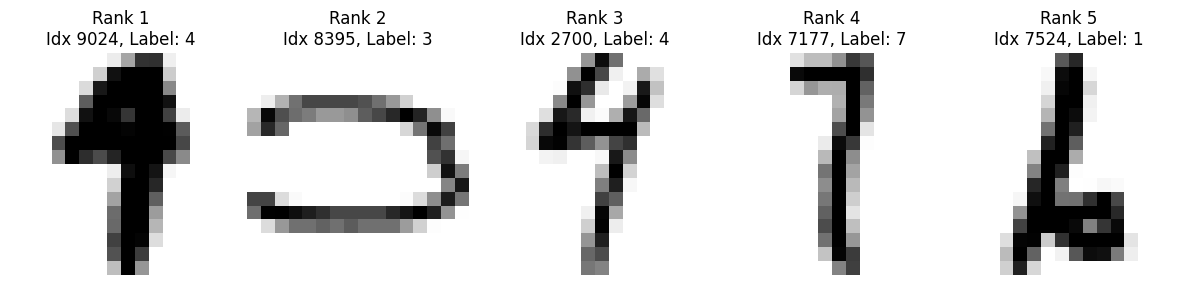

In [ ]:
## Q6 results
print("Q6 Results: Samples that were hardest to predict")

# compute the mistake rates for the samples and get the top 5 hardest to predict samples
valid_mask = sample_test_counts > 0
mistake_rates = np.zeros(n_samples)
mistake_rates[valid_mask] = sample_mistake_counts[valid_mask] / sample_test_counts[valid_mask]
top_indices = np.argsort(mistake_rates)[-5:][::-1]


q6_data = {
    "Rank": [i+1 for i in range(5)],
    "Index": top_indices,
    "True Label": [int(y_all[idx]) for idx in top_indices],
    "Error Rate": [f"{mistake_rates[idx]:.0%}" for idx in top_indices],
    "Mistakes/Tests": [f"{int(sample_mistake_counts[idx])}/{int(sample_test_counts[idx])}" for idx in top_indices]
}
q6_df = pd.DataFrame(q6_data).set_index("Rank")

# visualize hardest samples as binary images
fig, axes = plt.subplots(1, 5, figsize=(12, 3))

for rank, idx in enumerate(top_indices[:5]):
    ax = axes[rank]
    matrix = x_all[idx].reshape(16, 16)
    ax.imshow(matrix, cmap='gray_r')
    ax.set_title(f"Rank {rank+1}\nIdx {idx}, Label: {int(y_all[idx])}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Question 7

#### Question 7a) is in the report.

In [ ]:
"""
7b)
"""
class GaussianKernelPerceptron:
    """
    This is our implementation of the gaussian kernel perceptron. 
    This follows the same procedure as the polynomial kernel perceptron 
    but we redefine it here for clarity.
    """
    def __init__(self, c=0.01, epochs=5):
        self.c = c
        self.epochs = epochs
        self.active_indices = []
        self.alpha = []
    
    def train(self, y_train, gram_mtx):
        n_samples = len(y_train)
        self.active_indices = []
        self.alpha = []
        for _ in range(self.epochs):
            for i in range(n_samples):
                score = np.dot(self.alpha, gram_mtx[i, self.active_indices]) if self.active_indices else 0.0
                if np.sign(score) != y_train[i]:
                    self.active_indices.append(i)
                    self.alpha.append(y_train[i])

    def predict_scores(self, gram_test_train):
        if not self.active_indices:
            return np.zeros(gram_test_train.shape[0])
        return np.dot(gram_test_train[:, self.active_indices], self.alpha)

# find the squared distance matrix for the kernel so its precomputed
diag_gram = np.diag(gram_full)
sqdist = diag_gram[:, None] + diag_gram[None, :] - 2 * gram_full
sqdist[sqdist < 0] = 0

# initialize the parameters
S = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
results_train_g = np.zeros((run_count, len(S)))
results_test_g = np.zeros((run_count, len(S)))

print(f"7b): Running 20 runs for each c in {S}...")

# We redo the q3 procedure running OVR with the gaussian kernel
for run in range(run_count):
    print(f"Run {run+1}/{run_count}", end="\r")

    # shuffle the indices
    perm = np.random.permutation(n_samples)

    # split the data into train and test
    train_idx, test_idx = perm[:n_train], perm[n_train:]
    y_train, y_test = y_all[train_idx], y_all[test_idx]
    
    # iterate over all c values
    for i, c in enumerate(S):

        # compute the gaussian kernel
        gram_train = np.exp(-c * sqdist[np.ix_(train_idx, train_idx)])
        classifiers = {}

        # train the model
        for label in np.unique(y_train):
            gk_class = GaussianKernelPerceptron(c=c, epochs=5)
            gk_class.train(np.where(y_train == label, 1.0, -1.0), gram_train)
            classifiers[label] = gk_class
        
        # initialize the best scores and predictions
        best_scores = np.full(len(train_idx), -np.inf)
        train_pred = np.zeros(len(train_idx))

        # compute the scores for each class and select the best score
        for label, gk_class in classifiers.items():
            scores = gk_class.predict_scores(gram_train)
            mask = scores > best_scores
            best_scores[mask] = scores[mask]
            train_pred[mask] = label

        # compute the gaussian kernel for the test set
        gram_test = np.exp(-c * sqdist[np.ix_(test_idx, train_idx)])

        # initialize the best scores and predictions
        best_scores = np.full(len(test_idx), -np.inf)
        test_pred = np.zeros(len(test_idx))

        # compute the scores for the test set and select the best score
        for label, gk_class in classifiers.items():
            scores = gk_class.predict_scores(gram_test)
            mask = scores > best_scores
            best_scores[mask] = scores[mask]
            test_pred[mask] = label
        
        # compute the error rates for the train and test sets
        results_train_g[run, i] = np.mean(train_pred != y_train)
        results_test_g[run, i] = np.mean(test_pred != y_test)

# output results
q7b_df = pd.DataFrame({
    'c': S,
    'Train Error': [f"{np.mean(results_train_g[:, i]):.4f}±{np.std(results_train_g[:, i]):.4f}" for i in range(len(S))],
    'Test Error': [f"{np.mean(results_test_g[:, i]):.4f}±{np.std(results_test_g[:, i]):.4f}" for i in range(len(S))]
}).set_index('c')

print("7b) Results (Gaussian Kernel):")
print(q7b_df.to_string())


7b): Running 20 runs for each c in [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]...
7b) Results (Gaussian Kernel):
         Train Error     Test Error
c                                  
0.001  0.0560±0.0143  0.0747±0.0155
0.010  0.0005±0.0003  0.0280±0.0034
0.050  0.0002±0.0002  0.0394±0.0052
0.100  0.0001±0.0002  0.0553±0.0051
0.500  0.0000±0.0000  0.0687±0.0071
1.000  0.0000±0.0000  0.0699±0.0059
5.000  0.0000±0.0000  0.0709±0.0058


In [ ]:
# 7c) Guassian Kernel Cross Validation
def k_fold_cv_gaussian(sqdist, train_indices, y_train, S, k=5):
    """
    This is the implementation of cross validation for the gaussian kernel. The process 
    follows the same procedure that we did for the polynomial kernel.
    """

    # prepare samples for cross validation
    n_samples = len(train_indices)
    fold_size = n_samples // k
    sub_indices = np.arange(n_samples)
    np.random.shuffle(sub_indices)
    
    fold_errors = {c: [] for c in S}
    
    # iterate over the folds
    for fold in range(k):
        start = fold * fold_size
        end = (fold + 1) * fold_size if fold < k - 1 else n_samples

        # create the train and validation masks
        val_mask = np.zeros(n_samples, dtype=bool)
        val_mask[sub_indices[start:end]] = True
        train_mask = ~val_mask

        # get the current train and validation indices as well as the labels for the iteration
        curr_train_idx = train_indices[train_mask]
        curr_val_idx = train_indices[val_mask]
        curr_y_train = y_train[train_mask]
        curr_y_val = y_train[val_mask]

        # iterate over the c values that we chose
        for c in S:
            # compute the gaussian kernel
            gram_train = np.exp(-c * sqdist[np.ix_(curr_train_idx, curr_train_idx)])
            classifiers = {}

            # train the model
            for label in np.unique(curr_y_train):
                gk_class = GaussianKernelPerceptron(c=c, epochs=5)
                gk_class.train(np.where(curr_y_train == label, 1.0, -1.0), gram_train)
                classifiers[label] = gk_class
            
            # compute the gaussian kernel for the validation set
            gram_val = np.exp(-c * sqdist[np.ix_(curr_val_idx, curr_train_idx)])
            best_scores = np.full(len(curr_val_idx), -np.inf)
            test_pred = np.zeros(len(curr_val_idx))

            # compute the scores for each class and select the best score
            for label, gk_class in classifiers.items():
                scores = gk_class.predict_scores(gram_val)
                mask = scores > best_scores
                best_scores[mask] = scores[mask]
                test_pred[mask] = label

            # compute the error rate for the validation set
            fold_errors[c].append(np.mean(test_pred != curr_y_val))
    
    # compute the average error rate for each c
    avg_err = {c: np.mean(errs) for c, errs in fold_errors.items()}
    return min(avg_err, key=avg_err.get)

# Cross validation over 20 runs with the gaussina kernel, we store the results in the below lists
optimal_c_results = []
cv_train_res = []
cv_test_res = []

print("7c): Running 20 runs with 5-fold CV for Gaussian kernel...")

# perform cross validation over 20 runs
for run in range(run_count):
    print(f"Run {run+1}/{run_count}", end="\r")

    # shuffle the indices and split the data 
    perm = np.random.permutation(n_samples)
    train_idx, test_idx = perm[:n_train], perm[n_train:]
    y_train, y_test = y_all[train_idx], y_all[test_idx]
    
    # perform CV to find the best c
    optimal_c = k_fold_cv_gaussian(sqdist, train_idx, y_train, S, k=5)
    optimal_c_results.append(optimal_c)
    
    # train the model with the best c
    gram_train = np.exp(-optimal_c * sqdist[np.ix_(train_idx, train_idx)])
    classifiers = {}
    for label in np.unique(y_train):
        gk_class = GaussianKernelPerceptron(c=optimal_c, epochs=5)
        gk_class.train(np.where(y_train == label, 1.0, -1.0), gram_train)
        classifiers[label] = gk_class
    
    # predict on the training set
    best_scores = np.full(len(train_idx), -np.inf)
    train_pred = np.zeros(len(train_idx))
    for label, gk_class in classifiers.items():
        scores = gk_class.predict_scores(gram_train)
        mask = scores > best_scores
        best_scores[mask] = scores[mask]
        train_pred[mask] = label
    
    # predict the test set
    gram_test = np.exp(-optimal_c * sqdist[np.ix_(test_idx, train_idx)])
    best_scores = np.full(len(test_idx), -np.inf)
    preds_te = np.zeros(len(test_idx))
    for label, gk_class in classifiers.items():
        scores = gk_class.predict_scores(gram_test)
        mask = scores > best_scores
        best_scores[mask] = scores[mask]
        preds_te[mask] = label
    
    # compute the error rates for the training and test sets
    cv_train_res.append(np.mean(train_pred != y_train))
    cv_test_res.append(np.mean(preds_te != y_test))

# Results table output
unique, counts = np.unique(optimal_c_results, return_counts=True)

q7c_df = pd.DataFrame({
    'Metric': ['Mean c*', 'Train Error', 'Test Error'],
    'Value': [
        f"{np.mean(optimal_c_results):.4f}±{np.std(optimal_c_results):.4f}",
        f"{np.mean(cv_train_res):.4f}±{np.std(cv_train_res):.4f}",
        f"{np.mean(cv_test_res):.4f}±{np.std(cv_test_res):.4f}"
    ]
}).set_index('Metric')

print("7c) Results (Gaussian Kernel with CV):")
print(q7c_df.to_string())
print(f"Distribution of c*: {dict(zip(unique, counts))}")


7c): Running 20 runs with 5-fold CV for Gaussian kernel...
7c) Results (Gaussian Kernel with CV):
                     Value
Metric                    
Mean c*      0.0100±0.0000
Train Error  0.0005±0.0003
Test Error   0.0282±0.0040
Distribution of c*: {0.01: 20}


### 7d) Discussion is in the latex pdf.

# Question 8

### 8a) Research is in the latex pdf.

In [ ]:
"""
8b)
"""
class OneVsOneClassifier:
    """
    This is the implementation of the one versus one classifier as described in the latex pdf.
    """
    def __init__(self, d=1, epochs=5):
        """
        Initialize the parameters where d is the degree of the polynomial kernel, epochs is the number of epochs, 
        classifiers is a dictionary of the classifiers for each pair of classes and classes is the list of classes.
        """
        self.d = d
        self.epochs = epochs
        self.classifiers = {}
        self.classes = []
        
    def train(self, y_train, gram_full, train_indices):
        self.classes = np.unique(y_train)
        self.classifiers = {}
        n_classes = len(self.classes)
        
        # double for loop to iterate over all pairs of classes
        for i in range(n_classes):
            for j in range(i + 1, n_classes):

                # get relevant pair of classes and the mask for that pair
                c1, c2 = self.classes[i], self.classes[j]
                mask_pair = (y_train == c1) | (y_train == c2)
                local_idx = np.where(mask_pair)[0]

                # get the global indices of the pair of classes
                subset_global_idx = train_indices[local_idx]
                
                # get the binary labels for the pair of classes
                y_binary = np.where(y_train[local_idx] == c1, 1.0, -1.0)

                # get the gram matrix for the pair of classes
                gram_pair = gram_full[np.ix_(subset_global_idx, subset_global_idx)]
                
                # train the kernel perceptron for the pair of classes
                kp_class = KernelPerceptron(d=self.d, epochs=self.epochs)
                kp_class.train(y_binary, gram_pair)
                
                self.classifiers[(c1, c2)] = (kp_class, subset_global_idx)

    def predict(self, gram_full, test_indices):
        """
        The predict function implements the voting mechanism for the OVO
        classifier. It takes in the gram matrix and the test indices and returns
        the predicted class.
        """
        n_test = len(test_indices)
        votes = np.zeros((n_test, len(self.classes)))

        # this is the mapping of classes to their index which we will use for voting 
        class_to_idx = {c: i for i, c in enumerate(self.classes)}
        
        # iterate over all the classifiers
        for (c1, c2), (kp, subset_global_idx) in self.classifiers.items():
            # get the gram matrix for the test pair
            gram_pair = gram_full[np.ix_(test_indices, subset_global_idx)]
            # get the predictions and deterministically select 1 in the case of a tie
            predictions = np.where(kp.predict_scores(gram_pair)>= 0, 1.0, -1.0)
            # vote for the class
            votes[predictions > 0, class_to_idx[c1]] += 1
            votes[predictions < 0, class_to_idx[c2]] += 1
        # return the class with the most votes
        return self.classes[np.argmax(votes, axis=1)]

ovo_train_results = np.zeros((run_count, len(degrees)))
ovo_test_results = np.zeros((run_count, len(degrees)))

print("8b): Running 20 runs with OvO...")

# iterate over 20 runs and train each of the classifiers
for run in range(run_count):
    print(f"Run {run+1}/{run_count}", end="\r")
    
    # as we do in the other questions, suffle the data and split it into train and test
    perm = np.random.permutation(n_samples)
    train_idx, test_idx = perm[:n_train], perm[n_train:]
    y_train, y_test = y_all[train_idx], y_all[test_idx]
    
    # iterate of all the possible degrees and train the models
    for i, d in enumerate(degrees):
        model = OneVsOneClassifier(d=d, epochs=5)
        model.train(y_train, gram_full, train_idx)
        ovo_train_results[run, i] = np.mean(model.predict(gram_full, train_idx) != y_train)
        ovo_test_results[run, i] = np.mean(model.predict(gram_full, test_idx) != y_test)

print("8b) Results (OvO):")
print(f"{'Degree':<8} | {'Train Error':<20} | {'Test Error':<20}")
for i, d in enumerate(degrees):
    mt, st = np.mean(ovo_train_results[:, i]), np.std(ovo_train_results[:, i])
    me, se = np.mean(ovo_test_results[:, i]), np.std(ovo_test_results[:, i])
    print(f"{d:<8} | {mt:.4f} ± {st:.4f}       | {me:.4f} ± {se:.4f}")


8b): Running 20 runs with OvO...
8b) Results (OvO):
Degree   | Train Error          | Test Error          
1        | 0.0424 ± 0.0091       | 0.0703 ± 0.0104
2        | 0.0077 ± 0.0028       | 0.0413 ± 0.0040
3        | 0.0037 ± 0.0034       | 0.0362 ± 0.0048
4        | 0.0016 ± 0.0026       | 0.0340 ± 0.0063
5        | 0.0011 ± 0.0012       | 0.0338 ± 0.0037
6        | 0.0007 ± 0.0006       | 0.0332 ± 0.0046
7        | 0.0011 ± 0.0023       | 0.0364 ± 0.0052


In [ ]:
## 8c)
def k_fold_cv_ovo(gram_full, train_indices, y_train, degrees, k=5):
    """
    This is the implementation of cross validation for the one versus one classifier. This is a similar approach to the 
    approach we used in previous questions.
    """
    n_samples = len(train_indices)
    fold_size = n_samples // k
    sub_indices = np.arange(n_samples)
    np.random.shuffle(sub_indices)
    
    fold_errors = {d: [] for d in degrees}
    
    for fold in range(k):
        start = fold * fold_size
        end = (fold + 1) * fold_size if fold < k - 1 else n_samples
        
        # create the validation and train masks
        val_mask = np.zeros(n_samples, dtype=bool)
        val_mask[sub_indices[start:end]] = True
        train_mask = ~val_mask
        
        # get the current train and validation indices and labels
        curr_train_idx = train_indices[train_mask]
        curr_val_idx = train_indices[val_mask]
        curr_y_train = y_train[train_mask]
        curr_y_val = y_train[val_mask]
        
        # iterate over all the degrees and train each model
        for d in degrees:
            model = OneVsOneClassifier(d=d, epochs=5)
            model.train(curr_y_train, gram_full, curr_train_idx)
            preds = model.predict(gram_full, curr_val_idx)
            fold_errors[d].append(np.mean(preds != curr_y_val))
            
    avg_errors = {d: np.mean(errs) for d, errs in fold_errors.items()}
    return min(avg_errors, key=avg_errors.get)


# initialize the lists which will store the optimal dimensions and the error rates for training and testing.
optimal_dim_ovo = []
train_ovo_results = []
test_ovo_results = []

print("8c): Running 20 runs with 5-fold CV for OvO...")

# iterate over 20 runs rerunning the Q4 procedure using the OvO classifier
for run in range(run_count):
    print(f"Run {run+1}/{run_count}", end="\r")

    # prepare the data
    perm = np.random.permutation(n_samples)
    train_idx, test_idx = perm[:n_train], perm[n_train:]
    y_train, y_test = y_all[train_idx], y_all[test_idx]
    
    # run the cross validation to find the best d
    optimal_dim = k_fold_cv_ovo(gram_full, train_idx, y_train, degrees, k=5)
    optimal_dim_ovo.append(optimal_dim)
    
    # retrain with the best dimension
    model = OneVsOneClassifier(d=optimal_dim, epochs=5)
    model.train(y_train, gram_full, train_idx)
    
    # predict the train and test set
    pred_train = model.predict(gram_full, train_idx)
    pred_test = model.predict(gram_full, test_idx)
    
    # compute the error rates for the train and test sets
    train_ovo_results.append(np.mean(pred_train != y_train))
    test_ovo_results.append(np.mean(pred_test != y_test))

print("8c) Results (OvO with CV):")
print(f"Mean d*: {np.mean(optimal_dim_ovo):.2f} ± {np.std(optimal_dim_ovo):.2f}")
print(f"Mean Train Error: {np.mean(train_ovo_results):.4f} ± {np.std(train_ovo_results):.4f}")
print(f"Mean Test Error:  {np.mean(test_ovo_results):.4f} ± {np.std(test_ovo_results):.4f}")
unique, counts = np.unique(optimal_dim_ovo, return_counts=True)
print(f"Distribution of d*: {dict(zip(unique, counts))}")


8c): Running 20 runs with 5-fold CV for OvO...
8c) Results (OvO with CV):
Mean d*: 4.85 ± 1.01
Mean Train Error: 0.0009 ± 0.0008
Mean Test Error:  0.0315 ± 0.0034
Distribution of d*: {3: 3, 4: 3, 5: 8, 6: 6}


### 8d) Discussion is in the latex pdf